## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import keras
import seaborn as sns
from keras.applications import EfficientNetB3
import numpy as np
from sklearn.metrics import confusion_matrix
import zipfile
import os


2024-07-19 12:17:28.661577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 12:17:28.661685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 12:17:28.781024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Set Constants

In [2]:
IMG_SIZE=130
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
N_CLASSES = 10

## Import data into tensorflow dataset object

In [3]:
training= tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomatoleaf/tomato/train",
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomatoleaf/tomato/val",
    seed=123,
    shuffle=False,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [4]:
classes_name=training.class_names
classes_name

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
for batch_img,batch_label in training.take(1):
    print(batch_img.shape)
    print(batch_label.numpy())

(32, 130, 130, 3)
[5 0 0 2 3 6 6 4 6 4 0 3 4 0 1 5 7 5 2 8 3 6 8 3 2 4 0 7 8 6 1 5]


## Show some samples of images!

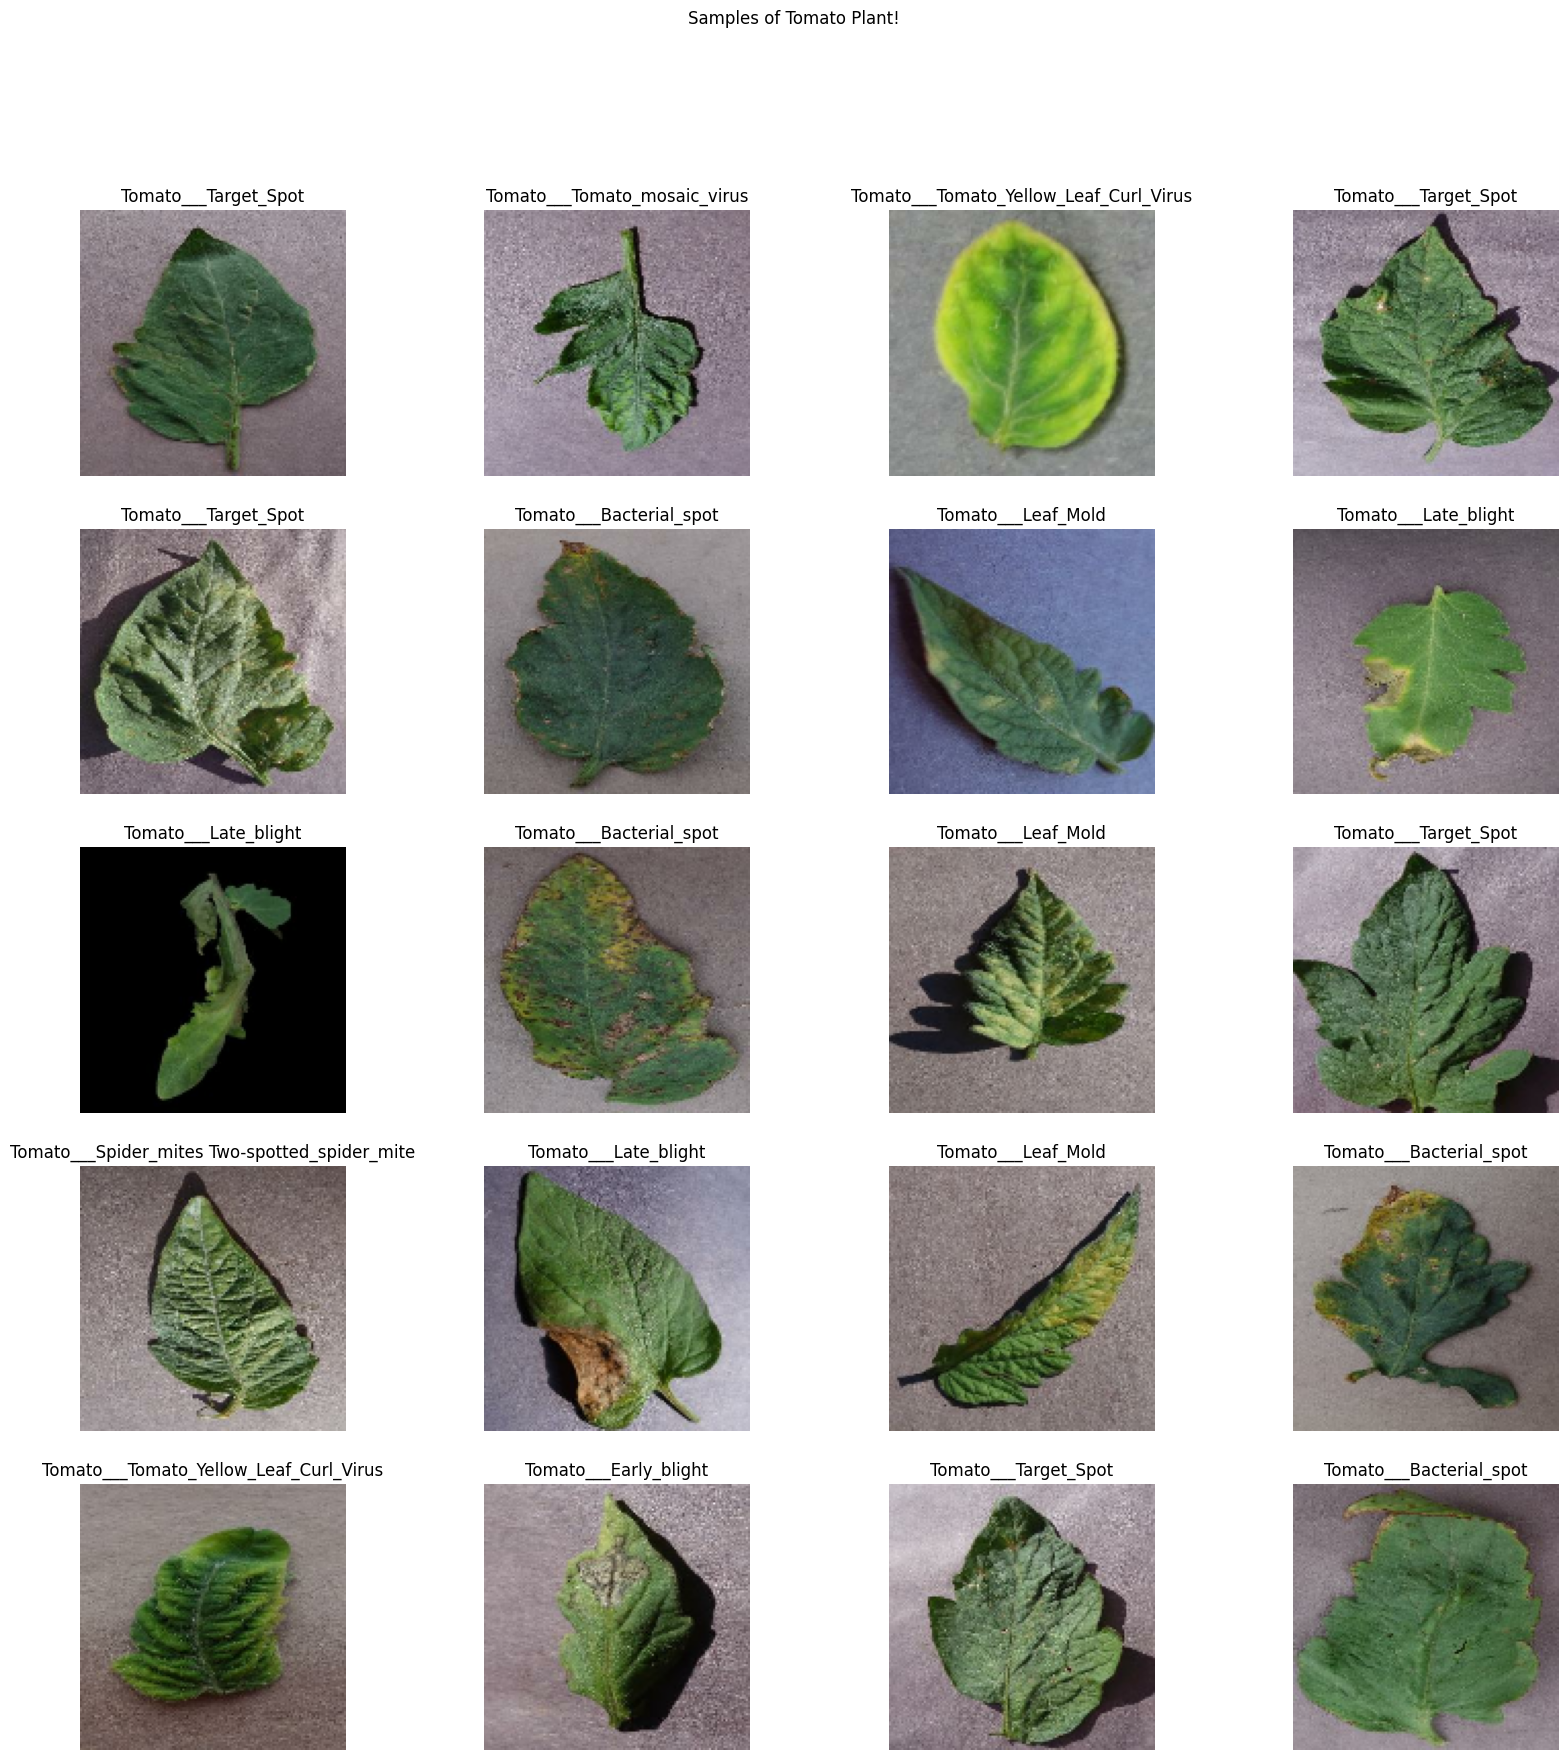

In [6]:
plt.figure(figsize=(20, 20))
plt.suptitle('Samples of Tomato Plant!')
for batch_img,batch_label in training.take(1):
   for i in range(20):
      ax=plt.subplot(5,4,i+1)
      plt.title(classes_name[batch_label[i]])
      plt.imshow(batch_img[i].numpy().astype('uint8'))
      plt.axis('off')

In [7]:
def split_train_val_test(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
   assert(train_split+val_split+test_split)==1


   if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    #set size of train,test and val
   train_size=int(train_split*len(dataset))
   val_size=int(val_split*len(dataset))
   test_size=int(test_split*len(dataset))


   train_ds=dataset.take(train_size)
   val_ds=dataset.skip(train_size).take(val_size)
   test_ds=dataset.skip(train_size+val_size).take(test_size)


   return train_ds,val_ds,test_ds



In [8]:
train,val,test=split_train_val_test(training)

In [9]:
print(len(train))
print(len(test))
print(len(val))

250
31
31


## Cache, Shuffle, and Prefetch the Dataset

In [10]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating a Layer for Resizing and Normalization

In [11]:
resize_scaling=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

## Build The Model

#### EfficientNetB3

In [12]:
base_model = EfficientNetB3(weights='imagenet',pooling='max',include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [13]:
model=tf.keras.models.Sequential([
    resize_scaling,
    base_model,
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(N_CLASSES,activation='softmax')

])


In [14]:
model.build(input_shape=INPUT_SHAPE)

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 130, 130, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (32, 1536)             │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 1536)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,981,561 (41.89 MB)

 Trainable params: 10,894,258 (41.56 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [16]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [17]:
history=model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1)
              #  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
              #                                            patience=5,
              #                                            restore_best_weights=True)])

Epoch 1/20


I0000 00:00:1721391640.538247      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 300s 549ms/step - accuracy: 0.6566 - loss: 1.2864 - val_accuracy: 0.0927 - val_loss: 6.8316
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.9413 - loss: 0.1997 - val_accuracy: 0.1724 - val_loss: 2.8501
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.9608 - loss: 0.1366 - val_accuracy: 0.6452 - val_loss: 1.6629
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.9829 - loss: 0.0552 - val_accuracy: 0.9435 - val_loss: 0.2245
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - accuracy: 0.9548 - loss: 0.1553 - val_accuracy: 0.9546 - val_loss: 0.1375
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - accuracy: 0.9803 - loss: 0.0664 - val_accuracy: 0.9546 - val_loss: 0.1692
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.9778 - loss: 0.0788 - val_accuracy: 0.9284 - val_loss: 0.2889
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.9571 - loss: 0.1451 - va

## Show The Model performance!

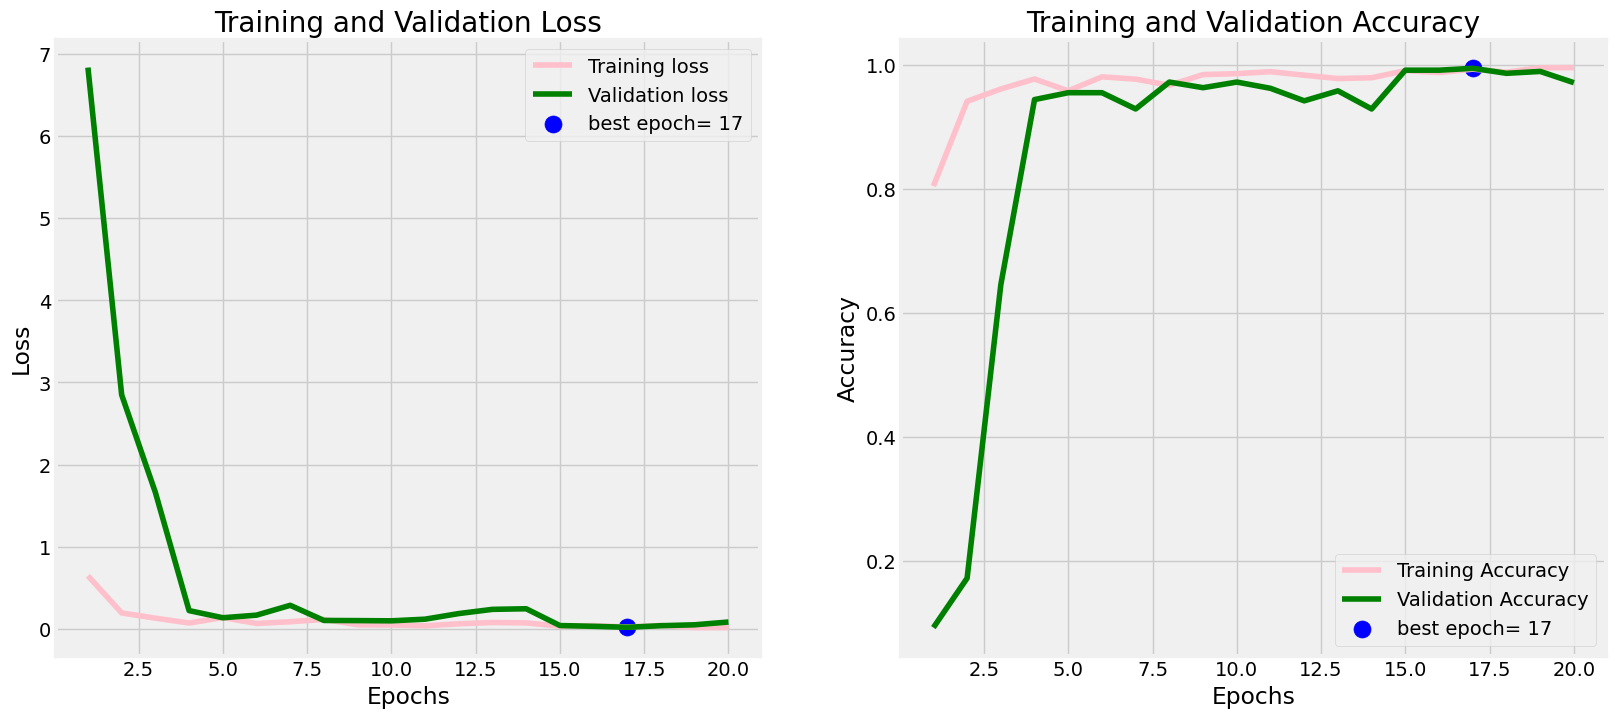

In [18]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'pink', label= 'Training loss')
plt.plot(Epochs, val_loss, 'green', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'pink', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'green', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Evaluate The Model

In [19]:
train_score = model.evaluate(train_ds, verbose= 1)
valid_score = model.evaluate(val_ds, verbose= 1)
test_score = model.evaluate(test_ds, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9796 - loss: 0.0642
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9713 - loss: 0.0794
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9642 - loss: 0.1180
Train Loss:  0.06951602548360825
Train Accuracy:  0.9780811667442322
--------------------
Validation Loss:  0.08565599471330643
Validation Accuracy:  0.9707661271095276
--------------------
Test Loss:  0.08214990049600601
Test Accuracy:  0.9677419066429138


## Get The Predictions!

In [20]:
def get_predicitions():
    all_true_labels = []
    all_predicted_labels = []
    all_images=[]
    classes_name=training.class_names

    #get all the predictions and true labels
    for image_batch, label_batch in test_ds:
            # Make predictions on the batch
            predictions = model.predict(image_batch)

            # Convert predictions to class indices
            predicted_labels = np.argmax(predictions, axis=1)

            #append matrix of images
            all_images.extend(image_batch)

            # Convert true labels to numpy array
            true_labels = label_batch

            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)



    #plot the predictions
    index=0
    plt.figure(figsize=(25, 25))
    plt.suptitle('Prediction of Tomato Disease!')

    for i in range(30,61):
        if index<15:
            ax=plt.subplot(5,3,index+1)
            color = 'green' if all_true_labels[i] == all_predicted_labels[i] else 'red'
            plt.title(f'true_class:{classes_name[all_true_labels[i]]}\npredicted_class{classes_name[all_predicted_labels[i]]}',color=color)
            plt.imshow(np.array(all_images[i]).astype('uint8'))
            plt.axis('off')
            index+=1
        else:
            index=0


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

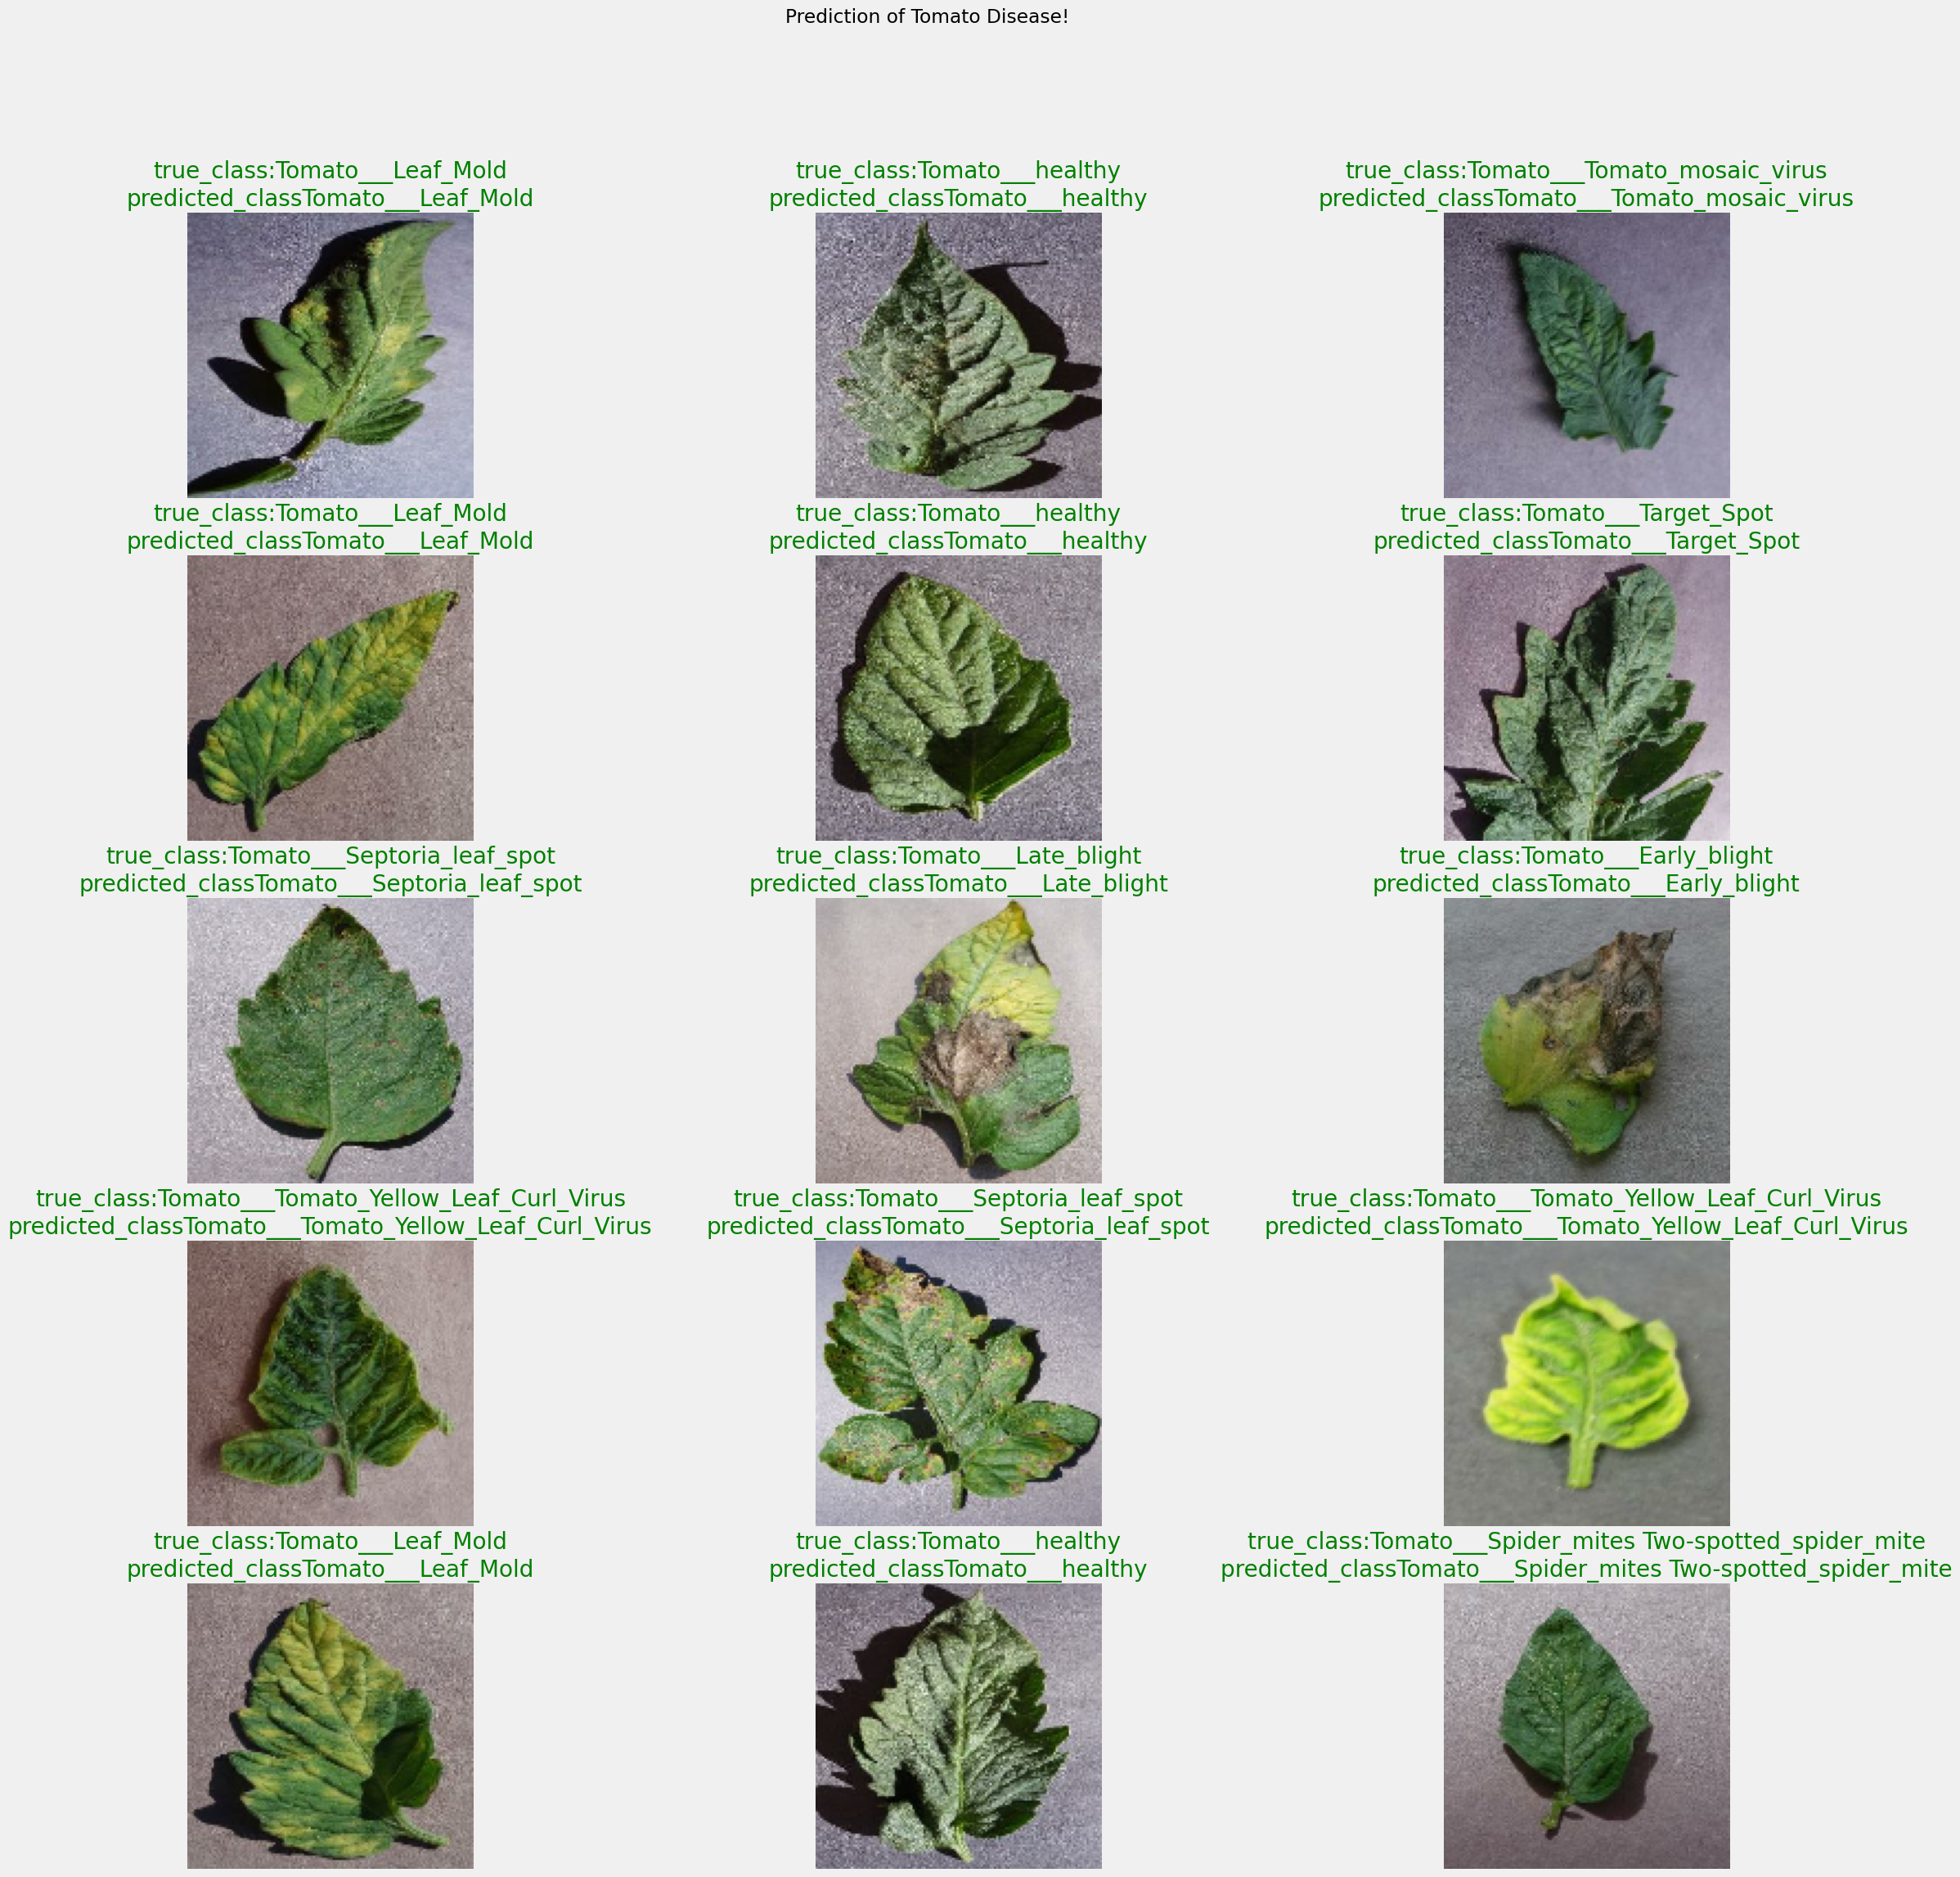

In [21]:
get_predicitions()

## Show Confusion Matrix!


In [22]:
def display_conf_matrix():
    all_true_labels=[]
    all_predicted_labels=[]
    for image_batch, label_batch in test_ds:
        # Make predictions on the batch
        predictions = model.predict(image_batch)

        # Convert predictions to class indices
        predicted_labels = np.argmax(predictions, axis=1)

        # Convert true labels to numpy array
        true_labels = label_batch.numpy()

        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

    # Convert lists to numpy arrays
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

        # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=training.class_names, yticklabels=training.class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

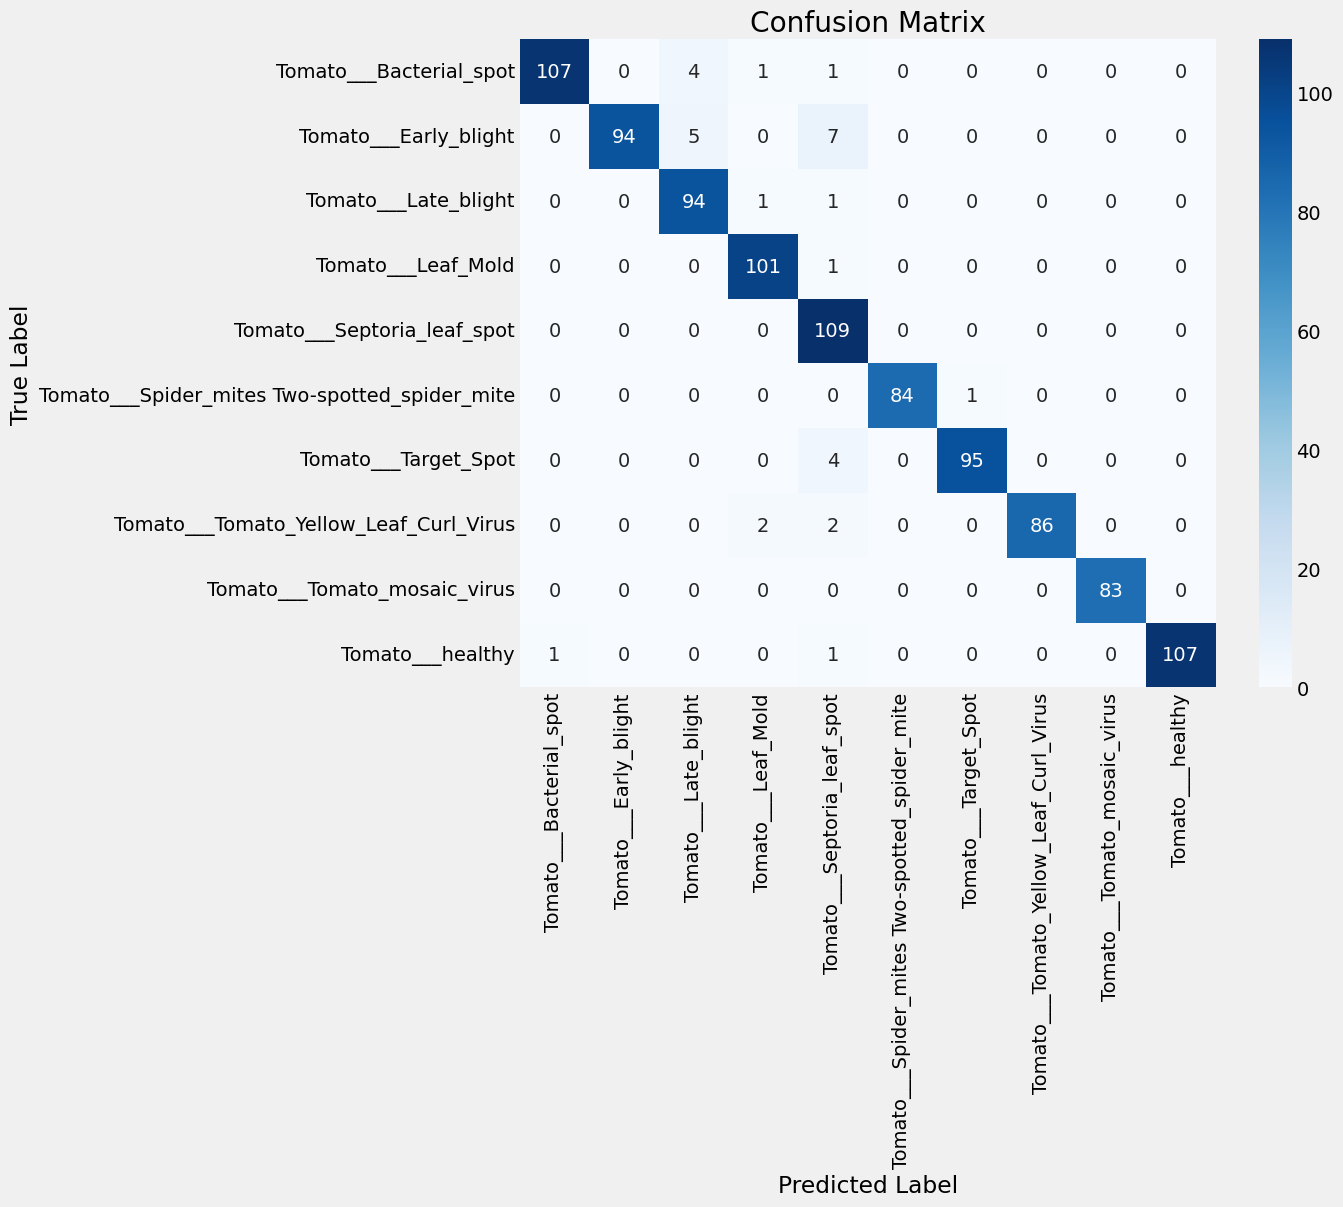

In [23]:
display_conf_matrix()